In [25]:
import pandas as pd
import numpy as np
import sklearn

from fredapi import Fred
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Gathering Initial Data for MVP

In [310]:
# Use FRED API to get latest releases in form of Series
fred = Fred(api_key = 'ef21eaa55b4aa6b62a37a05a6ba071c6')

# Series to pull
ten_year = fred.get_series_latest_release('GS10') #10 Year Treasury Yield
three_month = fred.get_series_latest_release('TB3MS') #3 Month Treasury Yield
recession = fred.get_series_latest_release('USREC') #Dummy variable for recession based on NBER
consumer_sent = fred.get_series_latest_release('UMCSENT') #U Michigan Consumer sentiment

In [311]:
fred_data = pd.concat([ten_year, three_month, consumer_sent, recession], axis=1).reset_index()
fred_data.columns = ['Date', '10_Year','3_Month','Consumer Sentiment','Recession']

In [312]:
fred_data.head()

,Date,10_Year,3_Month,Consumer Sentiment,Recession
0,1854-12-01,NaN,NaN,NaN,1.0
1,1855-01-01,NaN,NaN,NaN,0.0
2,1855-02-01,NaN,NaN,NaN,0.0
3,1855-03-01,NaN,NaN,NaN,0.0
4,1855-04-01,NaN,NaN,NaN,0.0


In [320]:
fred_data.dropna(inplace = True)
df = fred_data.copy()
df.reset_index(drop = True, inplace = True)

In [321]:
df['10Y-3M'] = df['10_Year'] - df['3_Month']

In [322]:
df.head(5)

,Date,10_Year,3_Month,Consumer Sentiment,Recession,10Y-3M
0,1953-08-01,2.95,2.04,80.8,1.0,0.91
1,1953-11-01,2.68,1.44,80.7,1.0,1.24
2,1954-02-01,2.47,0.97,82.0,1.0,1.50
3,1954-05-01,2.37,0.76,82.9,1.0,1.61
4,1954-11-01,2.48,0.93,87.0,0.0,1.55


## EDA

Have to shift yield spreads forward a certain amount of time to see if spreads have any predictive power
into future

Let's start with 6 months, 12 months, and 18 months

In [323]:
df['10Y-3M 6M Forward'] = df.loc[:,'10Y-3M'].shift(periods=6)
df['10Y-3M 12M Forward'] = df.loc[:,'10Y-3M'].shift(periods=12)
df['10Y-3M 18M Forward'] = df.loc[:,'10Y-3M'].shift(periods=18)

df['C Sentiment 6M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=6)
df['C Sentiment 12M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=12)
df['C Sentiment 18M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=18)

In [324]:
df.head(5)

,Date,10_Year,3_Month,Consumer Sentiment,Recession,10Y-3M,10Y-3M 6M Forward,10Y-3M 12M Forward,10Y-3M 18M Forward,C Sentiment 6M Forward,C Sentiment 12M Forward,C Sentiment 18M Forward
0,1953-08-01,2.95,2.04,80.8,1.0,0.91,NaN,NaN,NaN,NaN,NaN,NaN
1,1953-11-01,2.68,1.44,80.7,1.0,1.24,NaN,NaN,NaN,NaN,NaN,NaN
2,1954-02-01,2.47,0.97,82.0,1.0,1.50,NaN,NaN,NaN,NaN,NaN,NaN
3,1954-05-01,2.37,0.76,82.9,1.0,1.61,NaN,NaN,NaN,NaN,NaN,NaN
4,1954-11-01,2.48,0.93,87.0,0.0,1.55,NaN,NaN,NaN,NaN,NaN,NaN


In [318]:
# df.dropna(inplace = True)
# df = df.drop(['10Y-2Y', '10Y-3M'], axis=1)

Quick EDA and time series plots of the spread's predicition ability

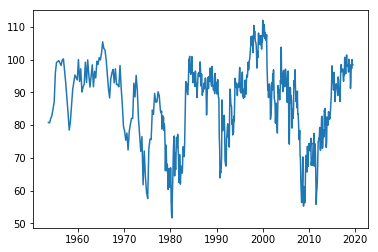

In [343]:
plt.plot(df['Date'], df['Consumer Sentiment']);

First take a look at current yield spreads vs. recessions

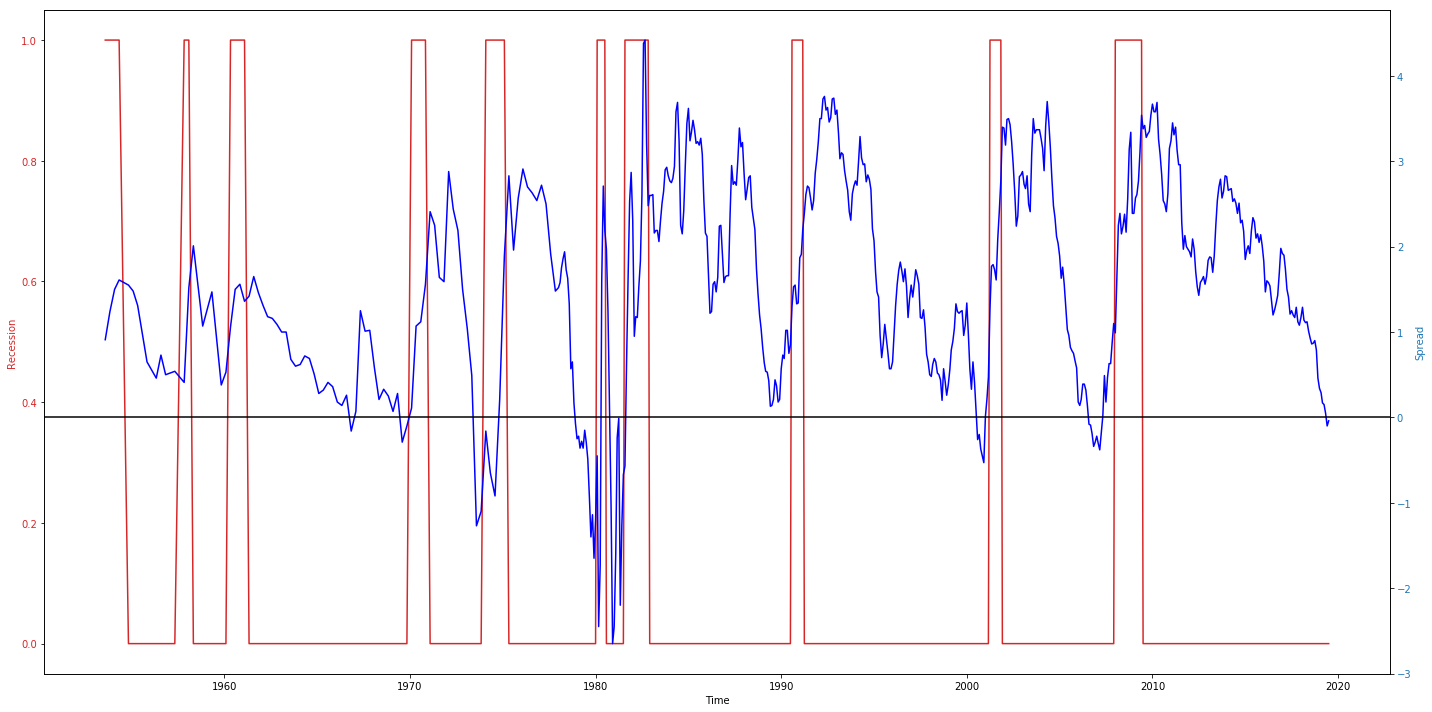

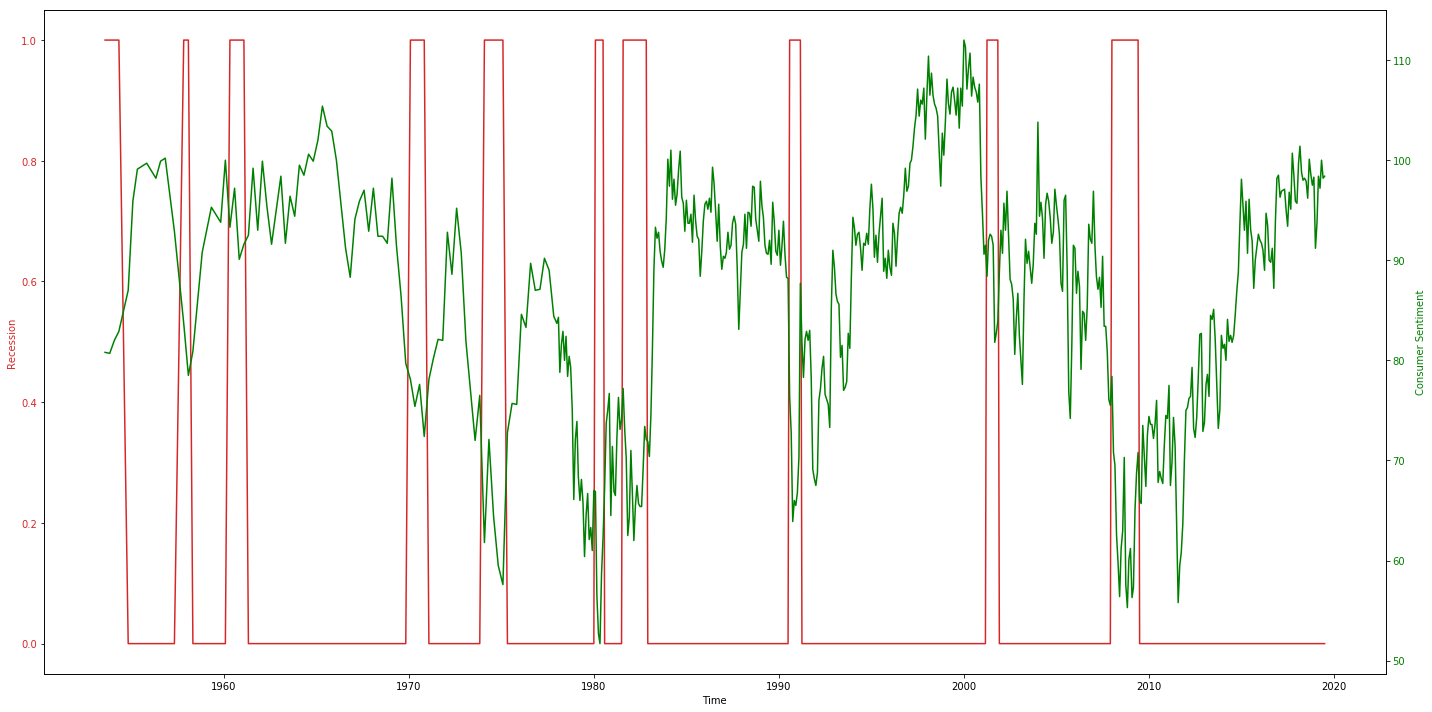

In [354]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['Consumer Sentiment'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show();

Certainly seems like spreads have lead the last few recessions. Now let's look at predictative ability of spreads for 6m, 12m, and 18m

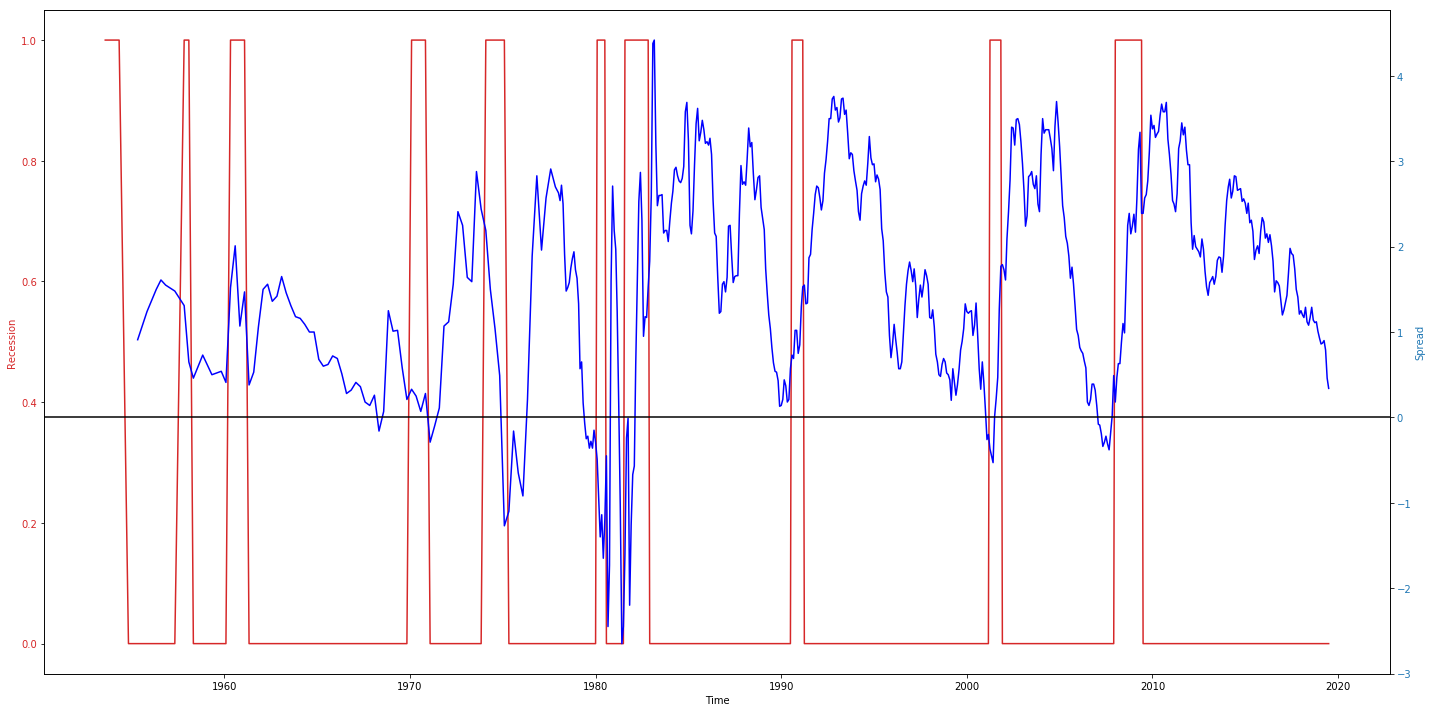

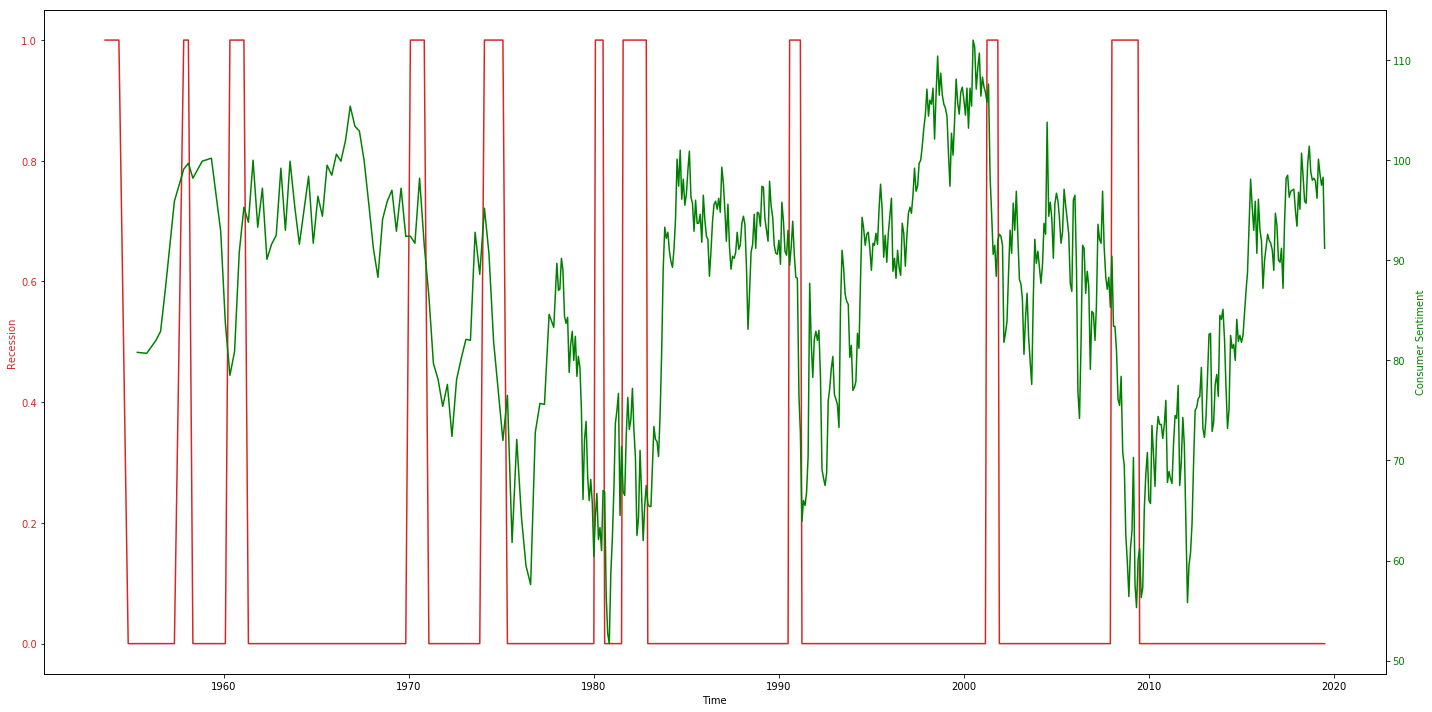

In [356]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M 6M Forward'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['C Sentiment 6M Forward'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show();

Not bad. Let's try 12 and 18 month as well

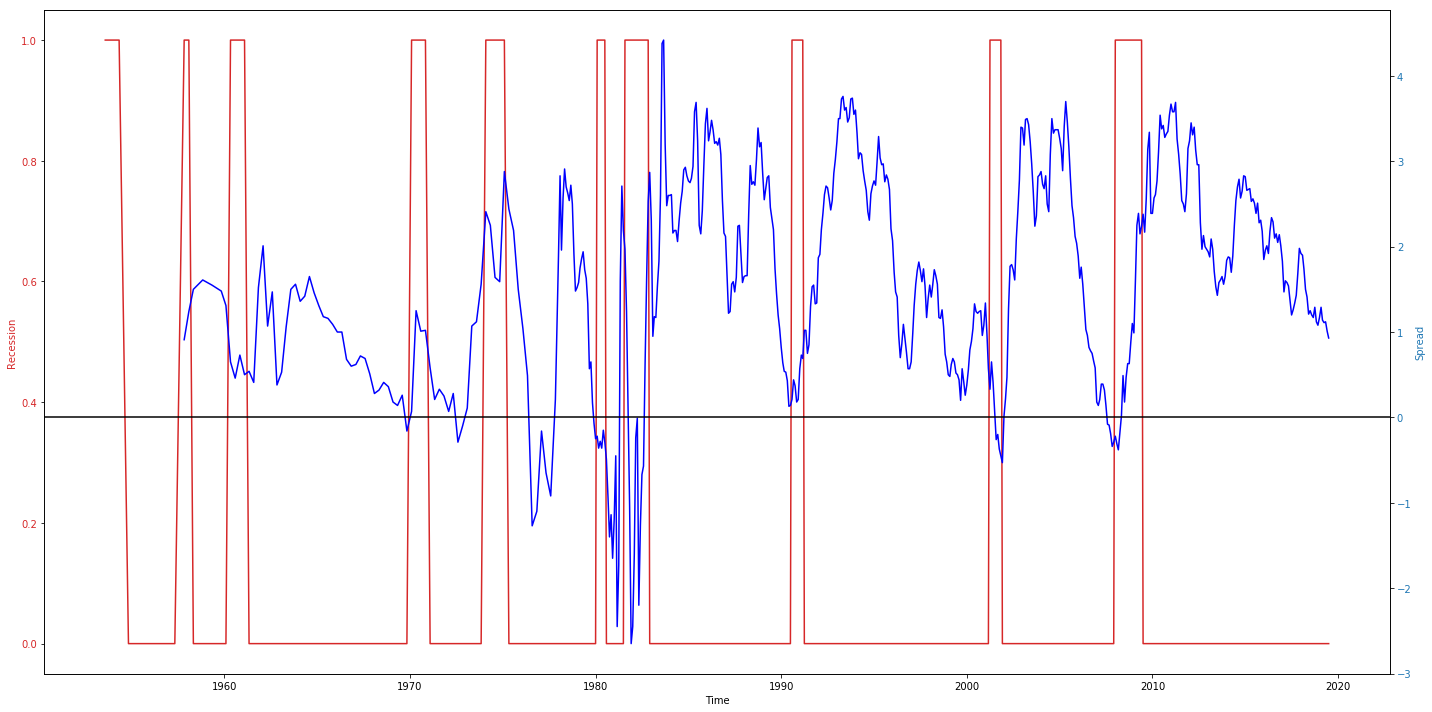

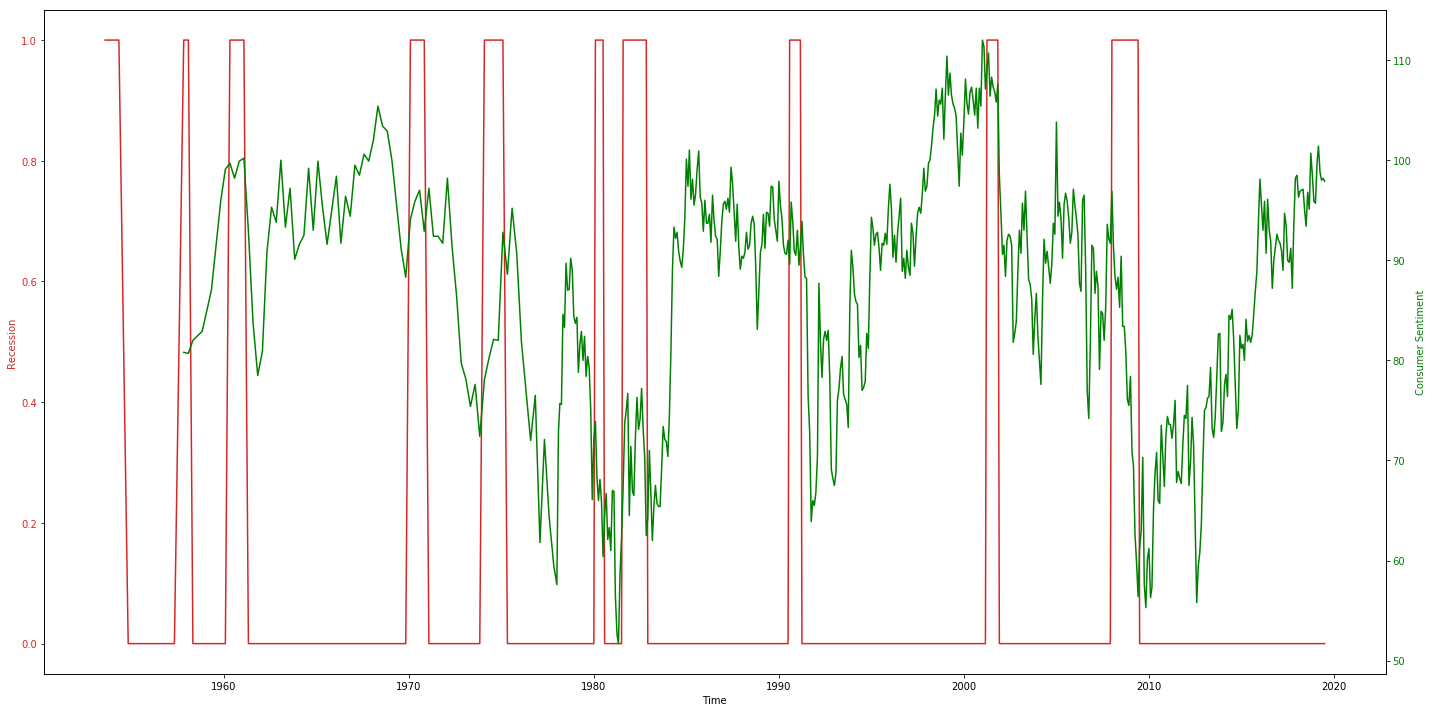

In [357]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M 12M Forward'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['C Sentiment 12M Forward'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show();

And one last time for 18 months

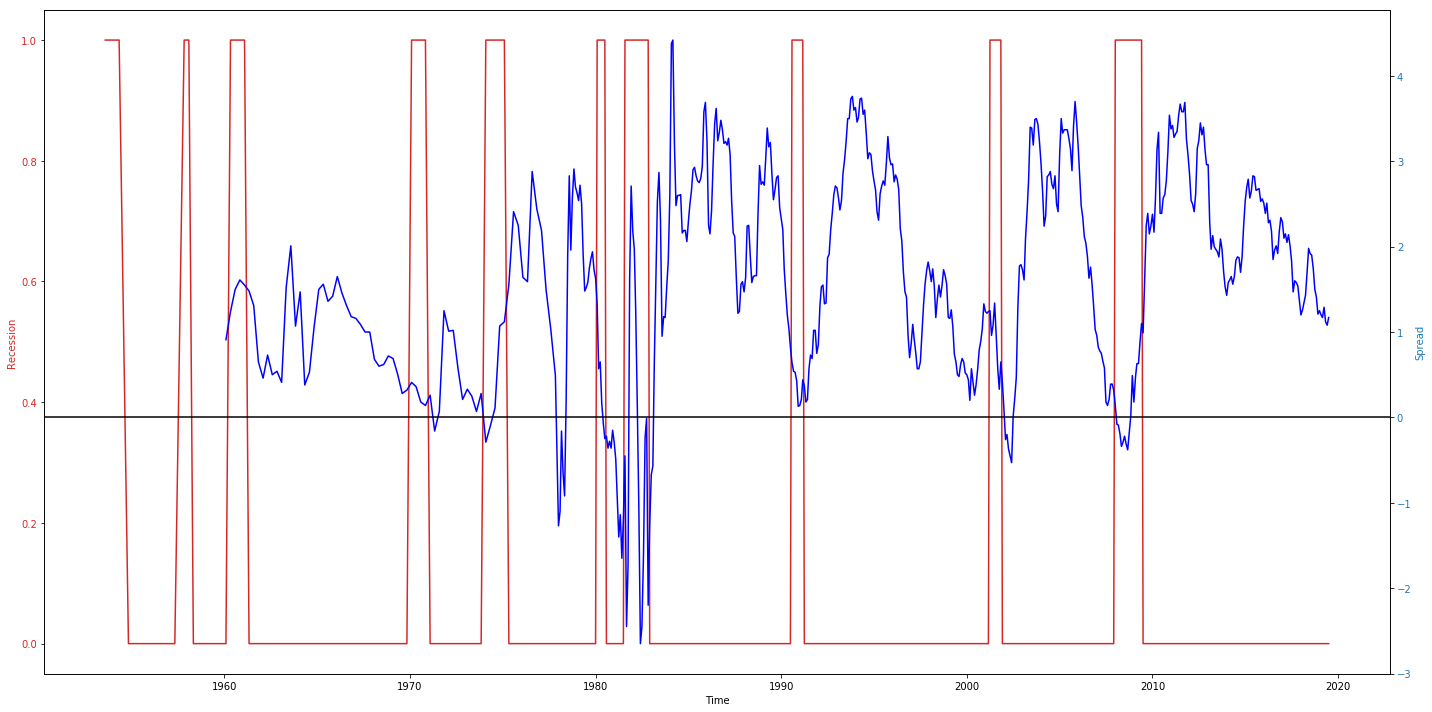

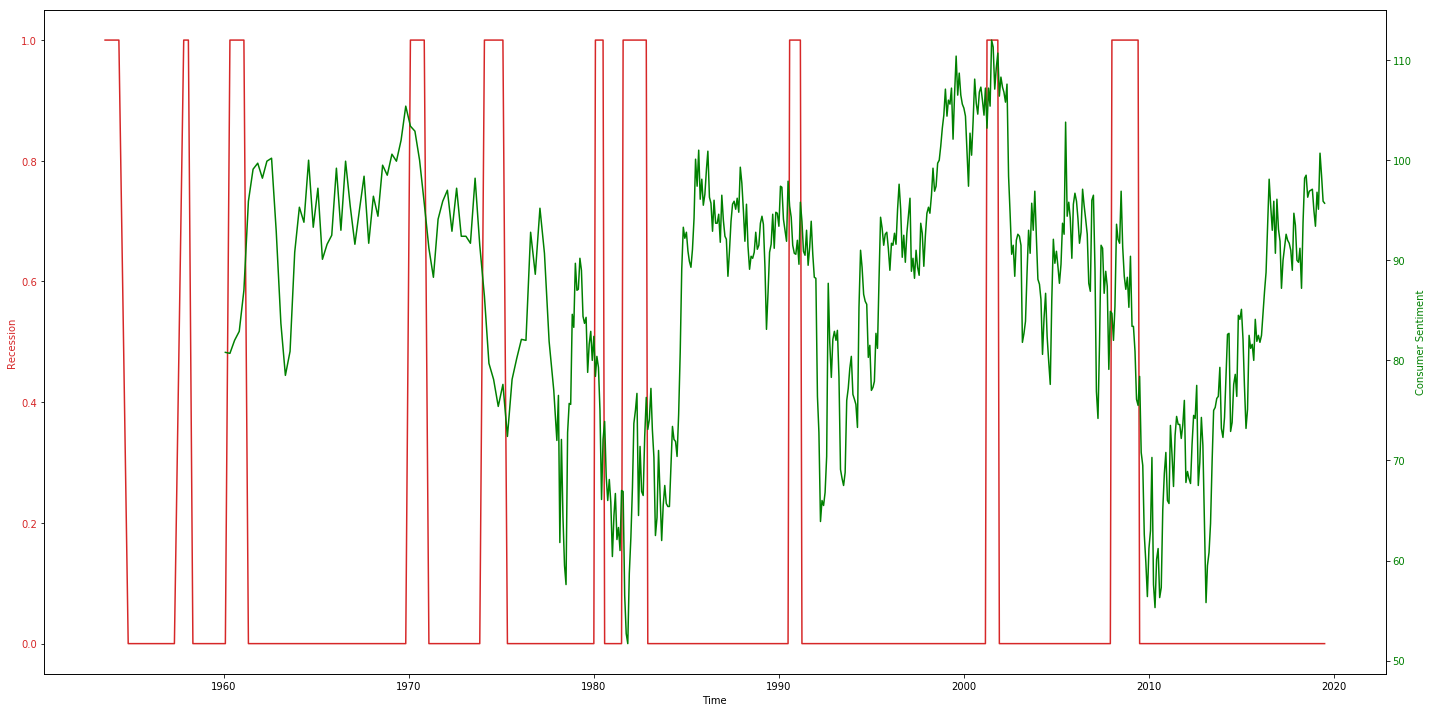

In [358]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M 18M Forward'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['C Sentiment 18M Forward'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show();

Overall, looks like the 6 month forward spread is best indicator of recession

## Logistic Regression for Recession Probabilities

In [440]:
df_logit = df[['Date','Recession','10Y-3M 6M Forward','C Sentiment 6M Forward']].copy()
df_logit.dropna(inplace = True)
#583 months

In [441]:
len(df_logit) * 0.666

388.278

In [442]:
cross_validation = df_logit[:388]
cross_validation = cross_validation.reset_index(drop = True)
test = df_logit[388:]
test = test.reset_index(drop = True)

In [443]:
test.head()

,Date,Recession,10Y-3M 6M Forward,C Sentiment 6M Forward
0,2003-05-01,0.0,2.82,84.2
1,2003-06-01,0.0,2.84,86.7
2,2003-07-01,0.0,2.88,82.4
3,2003-08-01,0.0,2.73,79.9
4,2003-09-01,0.0,2.68,77.6


In [444]:
y_train = cross_validation.Recession
y_test = test.Recession
X_train = cross_validation[['10Y-3M 6M Forward','C Sentiment 6M Forward']]
X_test = test[['10Y-3M 6M Forward','C Sentiment 6M Forward']]

In [445]:
std_scale = preprocessing.StandardScaler().fit(X_test)
X_test = std_scale.transform(X_test)

In [446]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)

In [447]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, y_train)
y_predict = logit.predict(X_test)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

The score for logistic regression is
Training:  87.11%
Test set:  90.77%
Default threshold:
Precision: 0.0000,   Recall: 0.0000


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [448]:
rec_probs = logit.predict_proba(X_test)
temp = pd.DataFrame(rec_probs)
temp['Date'] = test['Date']

In [449]:
temp.head()

,0,1,Date
0,0.942618,0.057382,2003-05-01
1,0.948193,0.051807,2003-06-01
2,0.941553,0.058447,2003-07-01
3,0.928871,0.071129,2003-08-01
4,0.920215,0.079785,2003-09-01


In [450]:
test = pd.concat([test, temp], axis=1)

In [451]:
test.dropna(inplace = True)
test.tail()

,Date,Recession,10Y-3M 6M Forward,C Sentiment 6M Forward,0,1,Date
190,2019-03-01,0.0,0.87,100.1,0.865167,0.134833,2019-03-01
191,2019-04-01,0.0,0.90,98.6,0.861397,0.138603,2019-04-01
192,2019-05-01,0.0,0.79,97.5,0.845546,0.154454,2019-05-01
193,2019-06-01,0.0,0.46,98.3,0.813226,0.186774,2019-06-01
194,2019-07-01,0.0,0.34,91.2,0.752991,0.247009,2019-07-01


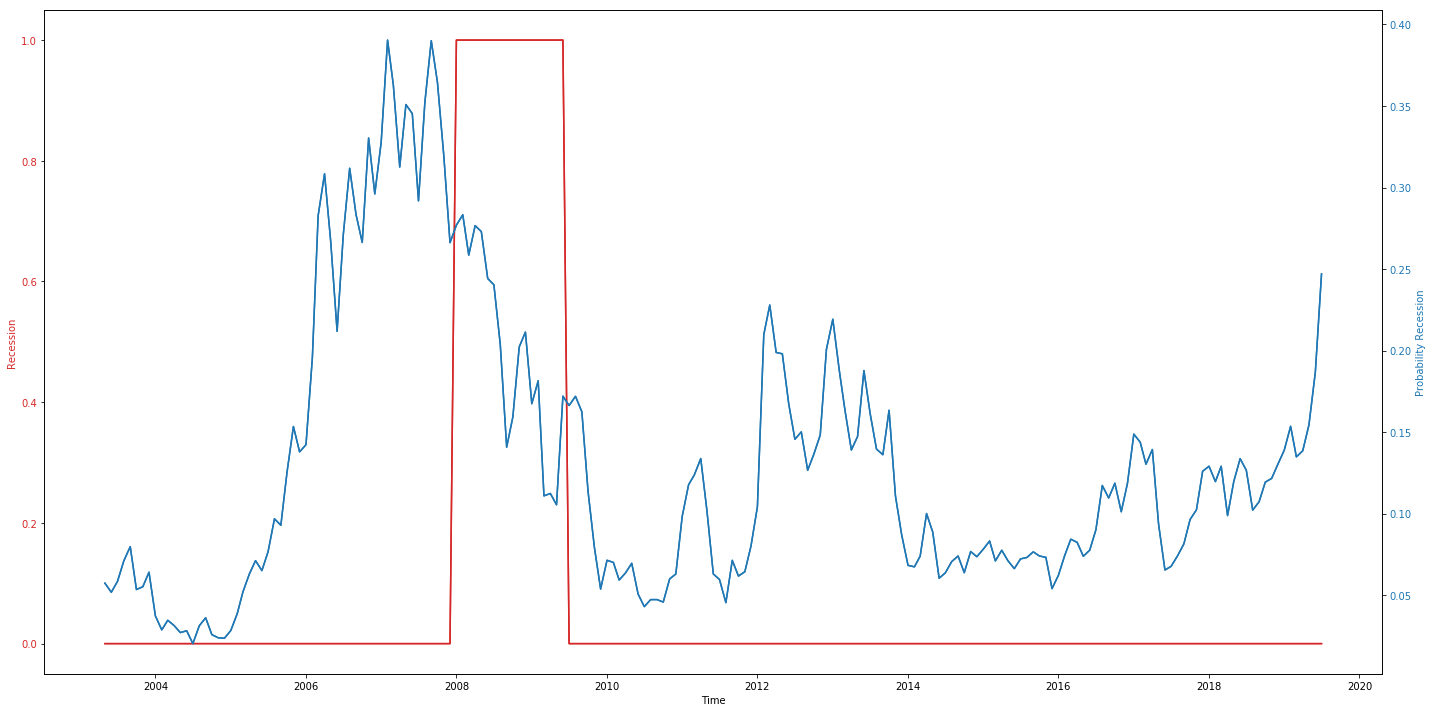

In [452]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(test['Date'], test['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Probability Recession', color=color)  
ax2.plot(test['Date'], test[1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Seems to be doing an ok job, but let's refit on entire dataset now

In [453]:
y = df_logit.Recession
X = df_logit[['10Y-3M 6M Forward','C Sentiment 6M Forward']]

In [455]:
std_scale = preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)

In [456]:
logit = LogisticRegression(C = 0.95)
logit.fit(X, y)
y_predict = logit.predict(X)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [457]:
rec_probs_2 = logit.predict_proba(X)
temp = pd.DataFrame(rec_probs_2)
temp.head()

,0,1
0,0.817172,0.182828
1,0.843975,0.156025
2,0.871792,0.128208
3,0.884281,0.115719
4,0.903017,0.096983


In [458]:
df_logit.reset_index(drop = True, inplace = True)
df_logit['Rec Prob'] = temp[1]

In [459]:
df_logit.head()

,Date,Recession,10Y-3M 6M Forward,C Sentiment 6M Forward,Rec Prob
0,1955-05-01,0.0,0.91,80.8,0.182828
1,1955-11-01,0.0,1.24,80.7,0.156025
2,1956-05-01,0.0,1.50,82.0,0.128208
3,1956-08-01,0.0,1.61,82.9,0.115719
4,1956-11-01,0.0,1.55,87.0,0.096983


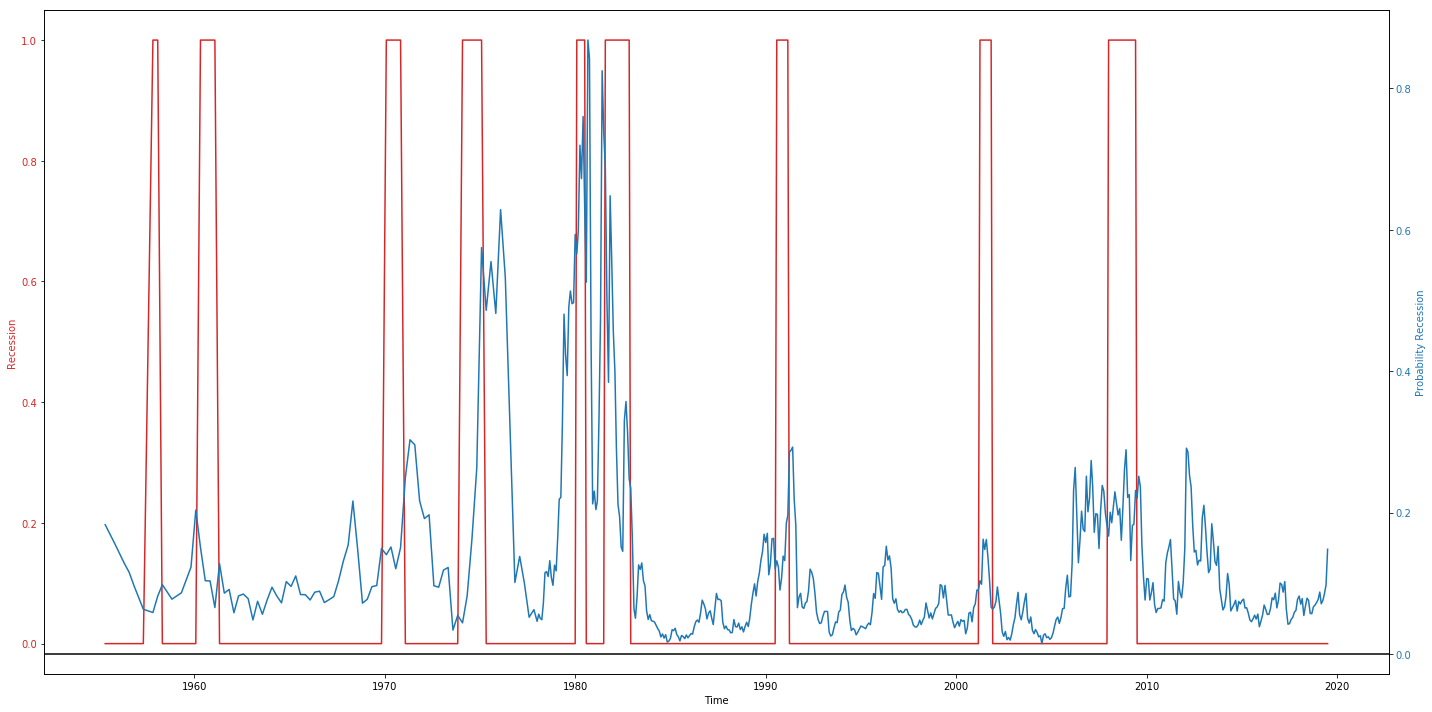

In [460]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df_logit['Date'], df_logit['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Probability Recession', color=color)  
ax2.plot(df_logit['Date'], df_logit['Rec Prob'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()